In [1]:
from IPython.display import HTML

HTML('''<script>
code_show=true; 
function code_toggle() {
 if (code_show){
 $('div.input').hide();
 } else {
 $('div.input').show();
 }
 code_show = !code_show
} 
$( document ).ready(code_toggle);
</script>
<form action="javascript:code_toggle()"><input type="submit" value="Click here to toggle on/off the raw code."></form>''')

In [2]:
import pandas as pd
from pprint import pprint
import gensim
import gensim.corpora as corpora
from gensim.utils import simple_preprocess
from gensim.parsing.preprocessing import STOPWORDS
from nltk.stem import WordNetLemmatizer, SnowballStemmer
from nltk.stem.porter import *
import numpy as np
import spacy
np.random.seed(2018)
stemmer = SnowballStemmer("english")

import nltk
nltk.download('wordnet')

import warnings
warnings.filterwarnings("ignore")

[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\Shreya\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


Reading Files

In [3]:
data= pd.read_csv('..\Data\data.csv')
data_whs= pd.read_csv('..\Data\data_whs.csv')
data6= pd.read_csv('..\Data\data6.csv')
data10= pd.read_csv('..\Data\data10.csv')
data15= pd.read_csv('..\Data\data15.csv')

## Running LDA for Data for 3rd Oct

In [4]:
# Size of the data 
print(data_whs.shape)
# data_whs.head()

(23837, 4)


In [5]:
# Reshuffling rows
from sklearn.utils import shuffle
data_whs = shuffle(data_whs)
# data_whs.head()

In [6]:
# Taking a Random Sample from the data. 10% of the original
data_whs1=data_whs[:2400]

In [7]:
# Function to Clean Data
def clean_data(df):
    data_text = df.Text.values.tolist()
    # Remove Emails
    data_text = [re.sub('\S*@\S*\s?', '', sent) for sent in data_text]
    # Remove new line characters
    data_text = [re.sub('\s+', ' ', sent) for sent in data_text]
    # Remove distracting single quotes
    data_text = [re.sub("\'", "", sent) for sent in data_text]
    # Removing words with length <4
    data_text = [re.sub(r'\b\w{1,4}\b', '', sent) for sent in data_text]
    return data_text

# Tokenizing words and cleaning up the text
def sent_to_words(sentences):
    for sentence in sentences:        
        yield(gensim.utils.simple_preprocess(str(sentence), deacc=True))  # deacc=True removes punctuations

# Remove Stop Words
def remove_stopwords(texts):
    return [[word for word in simple_preprocess(str(doc)) if word not in stop_words] for doc in texts]

#Lemmatizing
def lemmatization(texts, allowed_postags=['NOUN', 'ADJ', 'VERB', 'ADV']):
    """https://spacy.io/api/annotation"""
    texts_out = []
    for sent in texts:
        doc = nlp(" ".join(sent)) 
        texts_out.append([token.lemma_ for token in doc if token.pos_ in allowed_postags])
    return texts_out


In [8]:
stop_words = nltk.corpus.stopwords.words('english')
newStopWords = ['facebook','whatsapp','instagram','https']
stop_words.extend(newStopWords)

In [9]:
nlp = spacy.load("en_core_web_sm", disable=['parser', 'ner'])
data_text = clean_data(data_whs1)
data_words = list(sent_to_words(data_text))
data_words_nostops = remove_stopwords(data_words)
data_lemmatized = lemmatization(data_words_nostops, allowed_postags=['NOUN', 'ADJ', 'VERB', 'ADV'])

In [10]:
# Create Dictionary
id2word = corpora.Dictionary(data_lemmatized)
# Create Corpus
texts = data_lemmatized
# Term Document Frequency
corpus = [id2word.doc2bow(text) for text in texts]

In [11]:
# Build LDA model
lda_model = gensim.models.ldamodel.LdaModel(corpus=corpus,
                                           id2word=id2word,
                                           num_topics=10, 
                                           random_state=100,
                                           update_every=1,
                                           chunksize=100,
                                           passes=10,
                                           alpha='auto',
                                           per_word_topics=True)

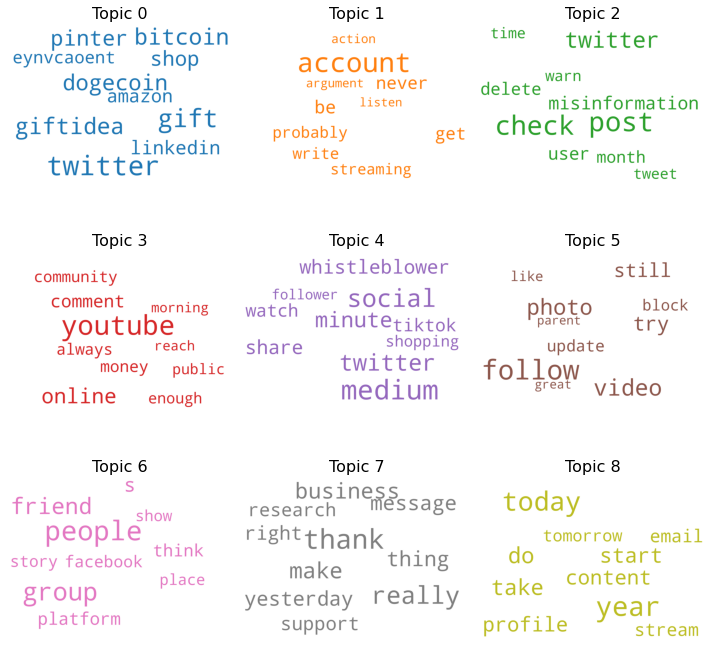

In [12]:
from matplotlib import pyplot as plt
from wordcloud import WordCloud, STOPWORDS
import matplotlib.colors as mcolors

cols = [color for name, color in mcolors.TABLEAU_COLORS.items()]  

cloud = WordCloud(stopwords=stop_words,
                  background_color='white',
                  width=2500,
                  height=1800,
                  max_words=10,
                  colormap='tab10',
                  color_func=lambda *args, **kwargs: cols[i],
                  prefer_horizontal=1.0)

topics = lda_model.show_topics(formatted=False)

fig, axes = plt.subplots(3, 3, figsize=(10,10), sharex=True, sharey=True)

for i, ax in enumerate(axes.flatten()):
    fig.add_subplot(ax)
    topic_words = dict(topics[i][1])
    cloud.generate_from_frequencies(topic_words, max_font_size=300)
    plt.gca().imshow(cloud)
    plt.gca().set_title('Topic ' + str(i), fontdict=dict(size=16))
    plt.gca().axis('off')


plt.subplots_adjust(wspace=0, hspace=0)
plt.axis('off')
plt.margins(x=0, y=0)
plt.tight_layout()
plt.show()

In [13]:
import pyLDAvis
import pyLDAvis.gensim_models as gensimvis
pyLDAvis.enable_notebook()
gensimvis.prepare(lda_model, corpus, id2word)

C:\Users\Shreya\anaconda3\lib\site-packages\sklearn\decomposition\_lda.py:28: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  EPS = np.finfo(np.float).eps


PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
6     -0.109538  0.284970       1        1  15.859827
0      0.321652  0.092216       2        1  13.363709
4      0.086320 -0.084607       3        1  12.161056
2      0.049868 -0.069740       4        1  11.060652
7     -0.074934  0.013088       5        1   9.980461
9     -0.068637 -0.070147       6        1   9.724076
3     -0.047163 -0.041812       7        1   8.260292
8     -0.054111 -0.047501       8        1   7.976099
5     -0.052302 -0.040974       9        1   7.324284
1     -0.051155 -0.035493      10        1   4.289545, topic_info=               Term        Freq       Total Category  logprob  loglift
50          twitter  290.000000  290.000000  Default  30.0000  30.0000
118            gift  149.000000  149.000000  Default  29.0000  29.0000
119        giftidea  120.000000  120.000000  Default  28.0000  28.0000
8           bitcoin  119.000000  119.000000  Default  27.0000  27.0000
13         dogecoin  113.000000  113.000000  Default  26.0000  26.0000
...             ...         ...         ...      ...      ...      ...
1871       disabled    2.965739    3.788058  Topic10  -5.4046   2.9043
330   administrator    2.897640    3.720003  Topic10  -5.4278   2.8992
33               nt    2.516808    3.339351  Topic10  -5.5687   2.8662
2985          quick    2.409757    3.232428  Topic10  -5.6122   2.8553
629             get   16.049762   37.039634  Topic10  -3.7160   2.3127

[344 rows x 6 columns], token_table=      Topic      Freq       Term
term                            
506       6  0.914945     access
20       10  0.977808    account
187       3  0.934637     accuse
329      10  0.933346     action
3121     10  0.728328     actual
...     ...       ...        ...
1428      1  0.959953      wrong
708       8  0.976973       year
661       5  0.969940  yesterday
1163      4  0.968292      young
157       7  0.990439    youtube

[317 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[7, 1, 5, 3, 8, 10, 4, 9, 6, 2])

## Running LDA for Data for 4th Oct

In [14]:
# # Size of the data 
print(data.shape)
# data.head()

(149700, 4)


C:\Users\Shreya\anaconda3\lib\site-packages\ipykernel\ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [15]:
# Taking a Random Sample from the data. 10% of the original
data1=data[:20000]

C:\Users\Shreya\anaconda3\lib\site-packages\ipykernel\ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [16]:
data_text_4 = clean_data(data1)
data_words_4 = list(sent_to_words(data_text_4))
data_words_nostops_4 = remove_stopwords(data_words_4)
data_lemmatized_4 = lemmatization(data_words_nostops_4, allowed_postags=['NOUN', 'ADJ', 'VERB', 'ADV'])

C:\Users\Shreya\anaconda3\lib\site-packages\ipykernel\ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [17]:
# Create Dictionary
id2word_4 = corpora.Dictionary(data_lemmatized_4)
# Create Corpus
texts_4 = data_lemmatized_4
# Term Document Frequency
corpus_4 = [id2word_4.doc2bow(text) for text in texts_4]

C:\Users\Shreya\anaconda3\lib\site-packages\ipykernel\ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [18]:
# Build LDA model
lda_model_4 = gensim.models.ldamodel.LdaModel(corpus=corpus_4,
                                           id2word=id2word_4,
                                           num_topics=10, 
                                           random_state=100,
                                           update_every=1,
                                           chunksize=100,
                                           passes=10,
                                           alpha='auto',
                                           per_word_topics=True)

C:\Users\Shreya\anaconda3\lib\site-packages\ipykernel\ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [19]:
import pyLDAvis
import pyLDAvis.gensim_models as gensimvis
pyLDAvis.enable_notebook()
gensimvis.prepare(lda_model_4, corpus_4, id2word_4)

C:\Users\Shreya\anaconda3\lib\site-packages\ipykernel\ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
4     -0.377611  0.085563       1        1  17.371825
9     -0.043936 -0.380763       2        1  15.212426
1      0.051442  0.041246       3        1  12.266124
2      0.052704  0.034908       4        1  11.621943
3      0.050829  0.040234       5        1  10.946839
7      0.056303  0.038923       6        1   9.013875
6      0.055378  0.036914       7        1   8.483889
5      0.055806  0.037729       8        1   6.358956
0      0.049543  0.032797       9        1   5.149144
8      0.049543  0.032449      10        1   3.574978, topic_info=              Term         Freq        Total Category  logprob  loglift
44         twitter  2230.000000  2230.000000  Default  30.0000  30.0000
165   facebookdown  3006.000000  3006.000000  Default  29.0000  29.0000
34    whatsappdown  1602.000000  1602.000000  Default  28.0000  28.0000
82       instadown   908.000000   908.000000  Default  27.0000  27.0000
41          outage   772.000000   772.000000  Default  26.0000  26.0000
...            ...          ...          ...      ...      ...      ...
204   freeshipping    21.705463    22.609876  Topic10  -4.9376   3.2904
931      servidore    18.268593    19.172067  Topic10  -5.1100   3.2829
3647         puede    16.457896    17.361370  Topic10  -5.2144   3.2778
3260         caido    16.240195    17.143807  Topic10  -5.2277   3.2771
2534          mile    16.350746    17.275603  Topic10  -5.2209   3.2762

[333 rows x 6 columns], token_table=       Topic      Freq       Term
term                             
14         4  0.989464     access
559        4  0.994230    account
490        1  0.995965   actually
15003      3  0.110309  adventure
15003      4  0.066185  adventure
...      ...       ...        ...
18240      2  0.019863      ywndz
18240      3  0.119178      ywndz
18240      6  0.039726      ywndz
18240      7  0.039726      ywndz
18240      8  0.794520      ywndz

[314 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[5, 10, 2, 3, 4, 8, 7, 6, 1, 9])

## Running LDA for Oct 6th Data

In [20]:
print(data6.shape)
# data6.head()

(8624, 4)


C:\Users\Shreya\anaconda3\lib\site-packages\ipykernel\ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [21]:
# Taking a Random Sample from the data. 10% of the original
data_6Oct1=data6[:1500]

C:\Users\Shreya\anaconda3\lib\site-packages\ipykernel\ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [22]:
data_text_6 = clean_data(data_6Oct1)
data_words_6 = list(sent_to_words(data_text_6))
data_words_nostops_6 = remove_stopwords(data_words_6)
data_lemmatized_6 = lemmatization(data_words_nostops_6, allowed_postags=['NOUN', 'ADJ', 'VERB', 'ADV'])

C:\Users\Shreya\anaconda3\lib\site-packages\ipykernel\ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [23]:
# Create Dictionary
id2word_6 = corpora.Dictionary(data_lemmatized_6)
# Create Corpus
texts_6 = data_lemmatized_6
# Term Document Frequency
corpus_6 = [id2word_6.doc2bow(text) for text in texts_6]

C:\Users\Shreya\anaconda3\lib\site-packages\ipykernel\ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [24]:
# Build LDA model
lda_model_6 = gensim.models.ldamodel.LdaModel(corpus=corpus_6,
                                           id2word=id2word_6,
                                           num_topics=10, 
                                           random_state=100,
                                           update_every=1,
                                           chunksize=100,
                                           passes=10,
                                           alpha='auto',
                                           per_word_topics=True)

C:\Users\Shreya\anaconda3\lib\site-packages\ipykernel\ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [25]:
import pyLDAvis
import pyLDAvis.gensim_models as gensimvis
pyLDAvis.enable_notebook()
gensimvis.prepare(lda_model_6, corpus_6, id2word_6)

C:\Users\Shreya\anaconda3\lib\site-packages\ipykernel\ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
8      0.369923 -0.007146       1        1  26.239869
9      0.330333 -0.004876       2        1  20.628757
0     -0.087265 -0.220614       3        1  10.064050
5     -0.084867  0.217073       4        1  10.014576
4     -0.091395 -0.121397       5        1   9.926844
2     -0.051282  0.121862       6        1   8.076534
3     -0.091379  0.008343       7        1   5.552826
7     -0.095896  0.002914       8        1   4.324381
1     -0.098577  0.003362       9        1   2.846600
6     -0.099595  0.000479      10        1   2.325562, topic_info=            Term        Freq       Total Category  logprob  loglift
22        tiktok  283.000000  283.000000  Default  30.0000  30.0000
17          gift  447.000000  447.000000  Default  29.0000  29.0000
13       bitcoin  418.000000  418.000000  Default  28.0000  28.0000
14      dogecoin  400.000000  400.000000  Default  27.0000  27.0000
18      giftidea  387.000000  387.000000  Default  26.0000  26.0000
...          ...         ...         ...      ...      ...      ...
3481      reider    1.565441    2.273173  Topic10  -5.3246   3.3882
3482  thereidout    1.565441    2.273173  Topic10  -5.3246   3.3882
3483     theview    1.565441    2.273173  Topic10  -5.3246   3.3882
1333     profile    1.503533    2.209902  Topic10  -5.3650   3.3761
1042     revenue    1.453485    2.159930  Topic10  -5.3988   3.3651

[358 rows x 6 columns], token_table=      Topic      Freq            Term
term                                 
1159      8  0.988169         account
295       1  0.921465        actually
3370      5  0.965702          addict
3507     10  0.878821           admin
945       5  0.896980          affect
...     ...       ...             ...
344       9  0.956146         youtube
1152      9  0.711910  youtubechannel
2251      9  0.919325        youtuber
768       4  0.896887           zucke
219       6  0.967750             zwq

[334 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[9, 10, 1, 6, 5, 3, 4, 8, 2, 7])

## Running LDA for Oct 10th Data

In [26]:
print(data10.shape)
# data10.head()

(4235, 4)


C:\Users\Shreya\anaconda3\lib\site-packages\ipykernel\ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [27]:
# Taking a Random Sample from the data. 10% of the original
data_10Oct1=data10[:600]

C:\Users\Shreya\anaconda3\lib\site-packages\ipykernel\ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [28]:
data_text_10 = clean_data(data_10Oct1)
data_words_10 = list(sent_to_words(data_text_10))
data_words_nostops_10 = remove_stopwords(data_words_10)
data_lemmatized_10 = lemmatization(data_words_nostops_10, allowed_postags=['NOUN', 'ADJ', 'VERB', 'ADV'])

C:\Users\Shreya\anaconda3\lib\site-packages\ipykernel\ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [29]:
# Create Dictionary
id2word_10 = corpora.Dictionary(data_lemmatized_10)
# Create Corpus
texts_10 = data_lemmatized_10
# Term Document Frequency
corpus_10 = [id2word_10.doc2bow(text) for text in texts_10]

C:\Users\Shreya\anaconda3\lib\site-packages\ipykernel\ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [30]:
# Build LDA model
lda_model_10 = gensim.models.ldamodel.LdaModel(corpus=corpus_10,
                                           id2word=id2word_10,
                                           num_topics=10, 
                                           random_state=100,
                                           update_every=1,
                                           chunksize=100,
                                           passes=10,
                                           alpha='auto',
                                           per_word_topics=True)

C:\Users\Shreya\anaconda3\lib\site-packages\ipykernel\ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [31]:
import pyLDAvis
import pyLDAvis.gensim_models as gensimvis
pyLDAvis.enable_notebook()
gensimvis.prepare(lda_model_10, corpus_10, id2word_10)

C:\Users\Shreya\anaconda3\lib\site-packages\ipykernel\ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
7     -0.457908 -0.003915       1        1  61.492016
9      0.092945  0.159839       2        1   7.372013
5     -0.178319  0.011755       3        1   5.970468
0      0.089280 -0.237226       4        1   5.164790
4      0.086625  0.047207       5        1   4.534149
2      0.062044  0.032423       6        1   3.481480
1      0.057269 -0.024460       7        1   3.271937
6      0.088754  0.035864       8        1   3.050973
3      0.070305 -0.035087       9        1   2.997575
8      0.089005  0.013598      10        1   2.664599, topic_info=            Term        Freq       Total Category  logprob  loglift
19      linkedin  150.000000  150.000000  Default  30.0000  30.0000
8       dogecoin  306.000000  306.000000  Default  29.0000  29.0000
14      shopping  132.000000  132.000000  Default  28.0000  28.0000
17       twitter  270.000000  270.000000  Default  27.0000  27.0000
26        pinter  143.000000  143.000000  Default  26.0000  26.0000
...          ...         ...         ...      ...      ...      ...
38         devop    0.883687    1.517419  Topic10  -5.2472   3.0845
252           re    0.883665    1.517406  Topic10  -5.2472   3.0844
1100       admin    0.835521    1.469251  Topic10  -5.3032   3.0607
1101       jitna    0.835521    1.469251  Topic10  -5.3032   3.0607
46    technology    1.197374    2.490889  Topic10  -4.9434   2.8926

[364 rows x 6 columns], token_table=      Topic      Freq      Term
term                           
67        4  0.235511   account
67        9  0.706533   account
760       2  0.775874     actor
1100     10  0.680619     admin
1223      8  0.588265     admit
...     ...       ...       ...
171       4  0.775531      year
60        3  0.953019  yoursize
49        6  0.963028   youtube
1238      9  0.553541      zboc
105       3  0.886585       zwq

[339 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[8, 10, 6, 1, 5, 3, 2, 7, 4, 9])

## Running LDA for 15th Oct

In [32]:
# # frames = [data15, whistleblower15]
# # data_15Oct= pd.concat(frames)
print(data15.shape)
# data15.head()

(4469, 4)


C:\Users\Shreya\anaconda3\lib\site-packages\ipykernel\ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [33]:
# Taking a Random Sample from the data. 10% of the original
data_15Oct1=data15[:750]

C:\Users\Shreya\anaconda3\lib\site-packages\ipykernel\ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [34]:
data_text_15 = clean_data(data_15Oct1)
data_words_15 = list(sent_to_words(data_text_15))
data_words_nostops_15 = remove_stopwords(data_words_15)
data_lemmatized_15 = lemmatization(data_words_nostops_15, allowed_postags=['NOUN', 'ADJ', 'VERB', 'ADV'])

C:\Users\Shreya\anaconda3\lib\site-packages\ipykernel\ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [35]:
# Create Dictionary
id2word_15 = corpora.Dictionary(data_lemmatized_15)
# Create Corpus
texts_15 = data_lemmatized_15
# Term Document Frequency
corpus_15 = [id2word_15.doc2bow(text) for text in texts_15]

C:\Users\Shreya\anaconda3\lib\site-packages\ipykernel\ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [36]:
# Build LDA model
lda_model_15 = gensim.models.ldamodel.LdaModel(corpus=corpus_15,
                                           id2word=id2word_15,
                                           num_topics=10, 
                                           random_state=100,
                                           update_every=1,
                                           chunksize=100,
                                           passes=10,
                                           alpha='auto',
                                           per_word_topics=True)

C:\Users\Shreya\anaconda3\lib\site-packages\ipykernel\ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [37]:
import pyLDAvis
import pyLDAvis.gensim_models as gensimvis
pyLDAvis.enable_notebook()
gensimvis.prepare(lda_model_15, corpus_15, id2word_15)

C:\Users\Shreya\anaconda3\lib\site-packages\ipykernel\ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
4      0.399418 -0.016093       1        1  37.996292
8      0.377241 -0.008086       2        1  25.379810
2     -0.096258  0.221799       3        1   7.440621
0     -0.126393 -0.173853       4        1   5.881198
6     -0.078391  0.035088       5        1   4.779971
1     -0.059005  0.031453       6        1   4.479405
3     -0.040053  0.030696       7        1   4.419124
7     -0.118436 -0.087348       8        1   3.316913
9     -0.128886 -0.013695       9        1   3.202994
5     -0.129236 -0.019962      10        1   3.103672, topic_info=            Term        Freq       Total Category  logprob  loglift
3           gift  595.000000  595.000000  Default  30.0000  30.0000
14        amazon  155.000000  155.000000  Default  29.0000  29.0000
15    eynvcaoent  150.000000  150.000000  Default  28.0000  28.0000
9         tumblr  211.000000  211.000000  Default  27.0000  27.0000
17      purchase  132.000000  132.000000  Default  26.0000  26.0000
...          ...         ...         ...      ...      ...      ...
1345      degene    1.790889    2.472066  Topic10  -4.8934   3.1502
875        label    1.559383    2.240576  Topic10  -5.0318   3.1101
202        right    2.175205    3.335850  Topic10  -4.6990   3.0450
203            s    1.224923    1.906375  Topic10  -5.2733   3.0303
556      milagro    1.213160    1.894337  Topic10  -5.2829   3.0269

[363 rows x 6 columns], token_table=      Topic      Freq       Term
term                            
1433     10  0.662337    abandon
1158      1  0.529438      acaba
680       4  0.922278    account
58        4  0.775362     accuse
1465      5  0.840720  advantage
...     ...       ...        ...
1453      8  0.669610    yiwdqzb
76        5  0.800643   yoursize
57        3  0.969616    youtube
1153      3  0.917729   youtuber
142       5  0.911648        zwq

[342 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[5, 9, 3, 1, 7, 2, 4, 8, 10, 6])